# Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

In [1]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

Cloning into 'GroceryStoreDataset'...
remote: Enumerating objects: 6559, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (231/231), done.
remote: Total 6559 (delta 45), reused 35 (delta 35), pack-reused 6293 (from 1)
Receiving objects: 100% (6559/6559), 116.26 MiB | 52.70 MiB/s, done.
Resolving deltas: 100% (275/275), done.


In [2]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple

In [3]:
class GroceryStoreDataset(Dataset):
    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target ~60%, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

In [4]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [9]:
# !pip install -q wandb
# !pip install -q torchmetrics
# !pip install -q torchinfo

In [10]:
import random
import copy
from copy import deepcopy

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import defaultdict
#from google.colab import drive
from pathlib import Path
from PIL import Image
from tqdm.notebook import tqdm
from typing import Any, Callable, Dict, List, Optional

from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torchmetrics.classification.accuracy import Accuracy
from torchvision.transforms import v2 as T
from torchinfo import summary

In [11]:
import wandb

WANDB_USER = "alessioarcara"  # insert your wandb username here
WANDB_PROJECT = "IPCV_ASSIGNMENT"

In [12]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(seed=42)

In [13]:
if torch.cuda.is_available():
    print("✅ CUDA GPU detected. Running on CUDA device.")
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    print("✅ MPS GPU detected. Running on MPS device.")
    device = torch.device("mps")
else:
    print("⚠️ No compatible GPU found. Running on CPU.")
    device = torch.device("cpu")

✅ CUDA GPU detected. Running on CUDA device.


In [57]:
cfg = {
    "resize_size": 384,
    "batch_size": 64,
    "num_epochs": 100,
    "ls": 0.1,
    "lr": 1e-3,
    "wd": 0.01,
}

In [58]:
data_transforms = {
    "train": T.Compose([
        T.ToImage(),
        T.RandomResizedCrop(cfg["resize_size"]),
        T.RandomHorizontalFlip(),
        T.ToDtype(torch.float32, scale=True),
    ]),

    "val": T.Compose([
        T.ToImage(),
        T.Resize(cfg["resize_size"]),
        T.ToDtype(torch.float32, scale=True),
    ])
}

In [59]:
train_dataset = GroceryStoreDataset("train", data_transforms["train"])
val_dataset = GroceryStoreDataset("val", data_transforms["val"])
test_dataset = GroceryStoreDataset("test", data_transforms["val"])

In [60]:
train_loader = DataLoader(
    train_dataset,
    batch_size=cfg["batch_size"],
    shuffle=True,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=cfg["batch_size"],
    shuffle=False
)

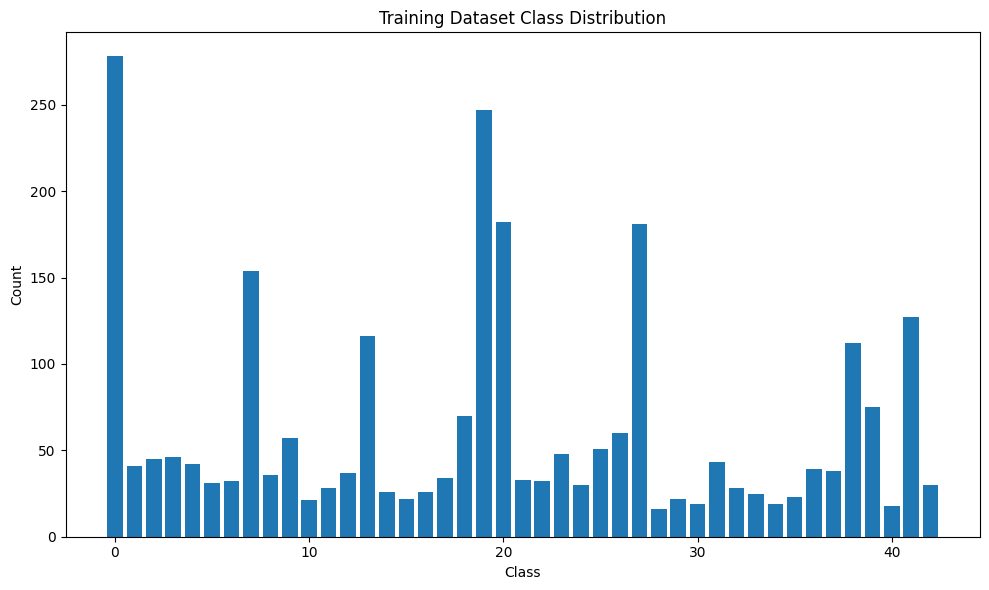

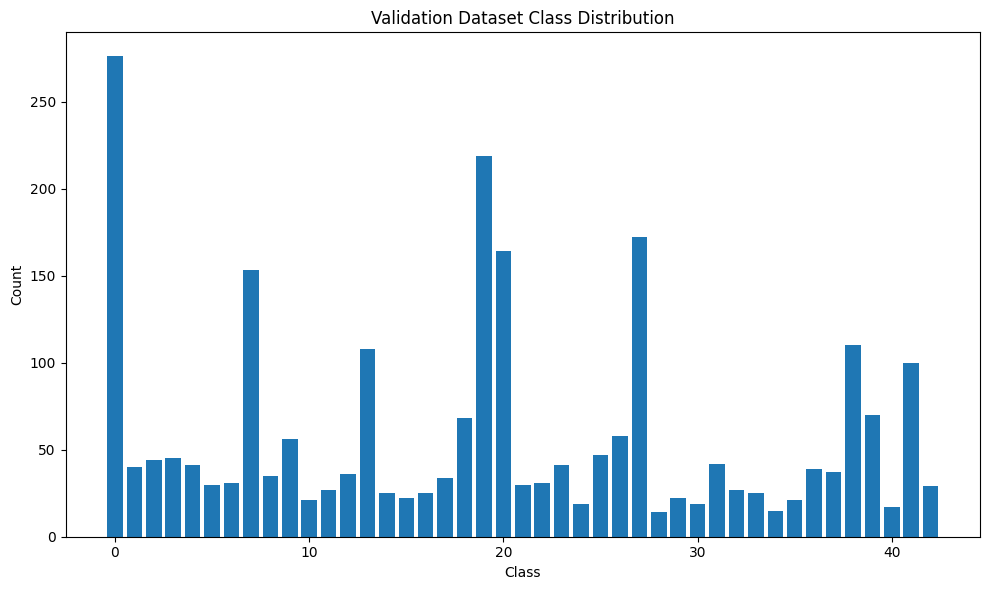

In [39]:
def plot_class_distribution(dataset, title="Class Distribution"):
    class_count = {}
    for _, label in dataset:
        class_count[label] = class_count.get(label, 0) + 1

    labels = list(class_count.keys())
    counts = list(class_count.values())

    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts)

    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_class_distribution(train_dataset, title="Training Dataset Class Distribution")
plot_class_distribution(test_dataset, title="Validation Dataset Class Distribution")

In [103]:
unique_sizes = set(img.size() for img, _ in test_dataset)
print(unique_sizes)

{torch.Size([3, 512, 384]), torch.Size([3, 384, 512]), torch.Size([3, 384, 384])}


In [20]:
len(train_dataset)

2640

In [99]:
def print_summary(net, input_size, verbose=True):
    from torchinfo import summary
    net_info = summary(net, input_size=input_size)
    params = net_info.total_params
    macs = net_info.total_mult_adds
    if verbose: print(net_info)
    print("\nNetwork's n°params: %.3fk \tMAC: %.3fM\n" % (params/1e3, macs/1e6))

In [100]:
class TinyShuffleNet(nn.Module):
    def __init__(self, in_channels, groups, num_classes=10):
        super(TinyShuffleNet, self).__init__()

        self.groups = groups

        self.conv1 = nn.Conv2d(3, in_channels, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.stage2 = self._make_stage(in_channels, in_channels * 2, num_blocks=2, stride=2)
        self.stage3 = self._make_stage(in_channels * 2, in_channels * 4, num_blocks=2, stride=2)
        self.stage4 = self._make_stage(in_channels * 4, in_channels * 8, num_blocks=2, stride=2)

        self.globalpool = nn.AdaptiveAvgPool2d(1)
        self.drop = nn.Dropout(0.5)
        self.fc = nn.Linear(in_channels * 8, num_classes)

    def _make_stage(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        for i in range(num_blocks):
            stride_layer = stride if i == 0 else 1
            layers.append(ShuffleUnit(in_channels, out_channels, stride=stride_layer, groups=self.groups))
            in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool(x)

        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)

        x = self.globalpool(x)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        x = self.fc(x)

        return x


class ShuffleUnit(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, groups=2):
        super(ShuffleUnit, self).__init__()
        self.stride = stride
        self.groups = groups

        self.out_channels = out_channels
        mid_channels = out_channels // 4

        # 1x1 GConv
        self.group_conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1, groups=groups, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_channels)

        # 3x3 DWConv
        self.depthwise_conv = nn.Conv2d(mid_channels, mid_channels, kernel_size=3,
                                      stride=stride, padding=1, groups=mid_channels, bias=False)
        self.bn2 = nn.BatchNorm2d(mid_channels)

        # 1x1 GConv
        self.group_conv2 = nn.Conv2d(mid_channels, out_channels if stride == 1 else out_channels - in_channels,
                                   kernel_size=1, groups=groups, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels if stride == 1 else out_channels - in_channels)

        # Shortcut
        if stride == 2:
            self.shortcut = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
        else:
            self.shortcut = nn.Identity()

    def channel_shuffle(self, x):
      batchsize, num_channels, height, width = x.size()
      channels_per_group = num_channels // self.groups
      x = x.view(batchsize, self.groups, channels_per_group, height, width)
      x = torch.transpose(x, 1, 2).contiguous()
      x = x.view(batchsize, -1, height, width)
      return x

    def forward(self, x):
        residual = self.shortcut(x)

        x = F.relu(self.bn1(self.group_conv1(x)))

        if self.groups > 1:
          x = self.channel_shuffle(x)

        x = self.bn2(self.depthwise_conv(x))
        x = self.bn3(self.group_conv2(x))

        if self.stride == 2:
            x = torch.cat([x, residual], 1)
        else:
            x = x + residual

        return F.relu(x)

In [101]:
class Trainer:
    def __init__(self,
            model: nn.Module,
            train_loader: DataLoader,
            val_loader: DataLoader,
            device: torch.device,
            num_classes: int
        ) -> None:
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.num_classes = num_classes
        self.num_epochs = cfg["num_epochs"]

        self.model = model.to(device)
        self.optimizer = AdamW(self.model.parameters(), lr=cfg["lr"], weight_decay=cfg["wd"])
        num_steps = self.num_epochs * len(train_loader)
        self.scheduler = OneCycleLR(self.optimizer, cfg["lr"], total_steps=num_steps)

        self.step = 0
        self.best_acc = 0.0

        wandb.init(name=cfg["run_name"], config=cfg)
        self.ckpt_path = Path("ckpts")
        self.ckpt_path.mkdir(exist_ok=True)

    def logfn(self, values: Dict[str, Any]) -> None:
        wandb.log(values, step=self.step, commit=False)

    def train(self) -> None:
        for _ in tqdm(range(self.num_epochs), desc="Epoch"):
            self.model.train()

            for imgs, labels in self.train_loader:
                imgs = imgs.to(self.device)
                labels = labels.to(self.device)

                pred = self.model(imgs)
                loss = F.cross_entropy(pred, labels, label_smoothing=cfg["ls"])

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                self.scheduler.step()

                if self.step % 10 == 0:
                    self.logfn({"train/loss": loss.item()})
                    self.logfn({"train/lr": self.scheduler.get_last_lr()[0]})

                self.step += 1

            self.eval("train")
            self.eval("val")

        wandb.finish()

    @torch.no_grad()
    def eval(self, split: str) -> None:
        self.model.eval()

        loader = self.train_loader if split == "train" else self.val_loader
        confusion_matrix = torch.zeros(self.num_classes, self.num_classes, dtype=torch.int)

        losses = []
        for imgs, labels in loader:
            imgs = imgs.to(self.device)
            labels = labels.to(self.device)

            scores = self.model(imgs)
            loss = F.cross_entropy(scores, labels)
            losses.append(loss.item())

            preds = torch.argmax(scores, dim=-1)
            for lbl, pred in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[lbl.long(), pred.long()] += 1

        mean_loss = sum(losses) / len(losses)
        accuracy = (torch.diagonal(confusion_matrix).sum() / confusion_matrix.sum()).item()

        self.logfn({f"{split}/loss": mean_loss})
        self.logfn({f"{split}/acc": accuracy})

        if split == "val":
            conf_mtrx_df = pd.DataFrame(confusion_matrix)
            plt.figure(figsize=(18, 15))
            heatmap = sn.heatmap(conf_mtrx_df, annot=True, fmt="d")
            plt.title(f"{split.capitalize()} Confusion Matrix")
            self.logfn({f"{split}/confusion_matrix": wandb.Image(heatmap.get_figure())})
            plt.close()

        if accuracy > self.best_acc and split == "val":
            self.best_acc = accuracy
            torch.save(self.model.state_dict(), self.ckpt_path / f"{wandb.run.name}.pt")
            self.best_model = copy.deepcopy(self.model)

In [102]:
model = TinyShuffleNet(96, 3, train_dataset.get_num_classes())
print_summary(model, (64, 3, 384, 384))

cfg["run_name"] = "SHUFFLE_96C3G_DROPOUT_LS"

trainer = Trainer(
    model,
    train_loader,
    val_loader,
    device,
    train_dataset.get_num_classes()
)

trainer.train()

Layer (type:depth-idx)                   Output Shape              Param #
TinyShuffleNet                           [64, 43]                  --
├─Conv2d: 1-1                            [64, 96, 192, 192]        2,592
├─BatchNorm2d: 1-2                       [64, 96, 192, 192]        192
├─MaxPool2d: 1-3                         [64, 96, 96, 96]          --
├─Sequential: 1-4                        [64, 192, 48, 48]         --
│    └─ShuffleUnit: 2-1                  [64, 192, 48, 48]         --
│    │    └─AvgPool2d: 3-1               [64, 96, 48, 48]          --
│    │    └─Conv2d: 3-2                  [64, 48, 96, 96]          1,536
│    │    └─BatchNorm2d: 3-3             [64, 48, 96, 96]          96
│    │    └─Conv2d: 3-4                  [64, 48, 48, 48]          432
│    │    └─BatchNorm2d: 3-5             [64, 48, 48, 48]          96
│    │    └─Conv2d: 3-6                  [64, 96, 48, 48]          1,536
│    │    └─BatchNorm2d: 3-7             [64, 96, 48, 48]          192
│  

train/loss,▁
train/lr,▁
train/loss,3.90216
train/lr,4e-05


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

train/acc,▁▃▃▄▄▅▅▅▅▆▆▆▇▇▆▇▇▇▇▇█▇█▇▇███████████████
train/loss,█▅▅▅▃▄▄▄▃▄▃▂▃▃▃▃▃▃▁▃▃▃▃▁▃▂▃▃▃▂▃▂▂▃▃▂▂▁▃▃
train/lr,▁▁▂▂▃▄▅▅▆▇█████████▇▇▇▇▇▇▆▅▅▅▄▄▃▃▃▂▂▂▂▂▁
val/acc,▁▃▃▅▅▅▅▅▅▆▆▆▆▇▆▇▆▇▇▇█▆█▇▇▇▇▇████████████
val/loss,█▆▅▄▄▃▃▃▄▂▂▂▂▃▂▂▂▁▁▂▁▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train/acc,0.97803
train/loss,0.17359
train/lr,0.0
val/acc,0.69932
val/loss,1.29939


## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.
1. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.

In [123]:
from torchvision.models import resnet18, ResNet18_Weights

weights = ResNet18_Weights.IMAGENET1K_V1
resnet18 = resnet18(weights=weights)

def set_requires_grad(layer: torch.nn.Module, train: bool) -> None:
    """Sets the requires_grad attribute to True or False for each parameter within a layer.

        Args:
            layer: the layer to freeze.
            train: if true train the layer.
    """
    for p in layer.parameters():
        p.requires_grad = train

set_requires_grad(resnet18.conv1, False)
set_requires_grad(resnet18.bn1, False)
set_requires_grad(resnet18.layer1, False)
set_requires_grad(resnet18.layer2, False)
set_requires_grad(resnet18.layer3, False)
set_requires_grad(resnet18.layer4, False)

resnet18.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(resnet18.fc.in_features, train_dataset.get_num_classes()),
)

print_summary(
    resnet18,
    input_size=(64, 3, cfg["resize_size"], cfg["resize_size"])
)

cfg["run_name"] = "resnet18_finetune"
cfg["num_epochs"] = 10

resnet18_trainer = Trainer(
    resnet18,
    train_loader,
    val_loader,
    device,
    train_dataset.get_num_classes()
)

resnet18_trainer.train()

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [64, 43]                  --
├─Conv2d: 1-1                            [64, 64, 192, 192]        (9,408)
├─BatchNorm2d: 1-2                       [64, 64, 192, 192]        (128)
├─ReLU: 1-3                              [64, 64, 192, 192]        --
├─MaxPool2d: 1-4                         [64, 64, 96, 96]          --
├─Sequential: 1-5                        [64, 64, 96, 96]          --
│    └─BasicBlock: 2-1                   [64, 64, 96, 96]          --
│    │    └─Conv2d: 3-1                  [64, 64, 96, 96]          (36,864)
│    │    └─BatchNorm2d: 3-2             [64, 64, 96, 96]          (128)
│    │    └─ReLU: 3-3                    [64, 64, 96, 96]          --
│    │    └─Conv2d: 3-4                  [64, 64, 96, 96]          (36,864)
│    │    └─BatchNorm2d: 3-5             [64, 64, 96, 96]          (128)
│    │    └─ReLU: 3-6                    [64, 64, 96, 96]  

train/acc,▁▃▅▆█
train/loss,▇▆▆▄▇▄▇█▅▅▃▅▅▄▄▃▄▄▅▅▂▄▄█▄▁
train/lr,▁▁▁▁▁▁▂▂▂▂▃▃▄▄▄▅▆▆▇▇█
val/acc,▁▄▆█
val/loss,█▅▃▁
train/acc,0.1
train/loss,3.71007
train/lr,1e-05
val/acc,0.0777
val/loss,3.79075


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

train/acc,▁▃▅▆▆▇▇███
train/loss,██▇▇▇▇▇▇▆▅▆▅▅▃▅▅▅▃▃▄▅▄▃▃▃▃▃▃▂▁▄▃▂▁▄▃▁▂▂▁
train/lr,▁▁▂▂▃▄▅▅▆▇▇███████▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁
val/acc,▁▃▄▅▆▇▇███
val/loss,█▆▅▃▃▂▁▁▁▁
train/acc,0.27045
train/loss,2.80524
train/lr,0.0
val/acc,0.31081
val/loss,2.90025


In [124]:
set_requires_grad(resnet18.conv1, True)
set_requires_grad(resnet18.bn1, True)
set_requires_grad(resnet18.layer1, True)
set_requires_grad(resnet18.layer2, True)
set_requires_grad(resnet18.layer3, True)
set_requires_grad(resnet18.layer4, True)

cfg["num_epochs"] = 10
cfg["lr"] = 1e-4

resnet18_trainer = Trainer(
    resnet18,
    train_loader,
    val_loader,
    device,
    train_dataset.get_num_classes()
)

resnet18_trainer.train()

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

train/acc,▁▄▆▇██████
train/loss,███▇▆▆▅▄▅▄▄▂▃▄▃▂▃▃▃▃▃▃▃▃▁▃▃▃▁▃▃▃▁▃▃▃▁▃▃▁
train/lr,▁▁▂▂▃▄▅▅▆▇▇███████▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁
val/acc,▁▄▅▆█▇████
val/loss,█▅▃▂▁▂▁▁▁▁
train/acc,0.97879
train/loss,0.22078
train/lr,0.0
val/acc,0.90203
val/loss,0.56993
